In [1]:
# using Pkg/
# Pkg.activate(".")

In [2]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools
using ControlSystems

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [3]:
#From RoadsMPC slide deck
#values are in m and degrees 
#orbits elements of und roads 1
#last is the true anomaly 
elements1 = [6885.635e3, 0.001089, 97.43, 0, 0, 0]

#orbital elements of und roads 2
#last is the true anomaly
elements2 = [6885.635e3, 0.001089, 97.43, 0, 0, 0.016667]

6-element Vector{Float64}:
  6.885635e6
  0.001089
 97.43
  0.0
  0.0
  0.016667

In [4]:
#convert the true anomaly to mean anomaly to be able to do the conversion and degrees to radians

In [5]:
function degrees_to_rad(x)

    return x*pi/180
    
end

degrees_to_rad (generic function with 1 method)

In [6]:
#v is true anomaly 
#e is the eccentricity
function true_anom_to_eccentric_anom(v, e)

    E = 2*atand(sqrt((1-e)/(1+e))*tand(v/2))

    #eccentric anomaly
    return E

end

true_anom_to_eccentric_anom (generic function with 1 method)

In [7]:
function eccentric_anom_to_mean_anom(E, e)

    M = E - e*sind(E)

    #mean anomaly
    return M

end

eccentric_anom_to_mean_anom (generic function with 1 method)

In [8]:
#eccentric anomaly sat 1
E1 = true_anom_to_eccentric_anom(elements1[end], elements1[2])

#mean anomaly sat 1
M1 = eccentric_anom_to_mean_anom(E1, elements1[2])

0.0

In [9]:
#eccentric anomaly sat 2
E2 = true_anom_to_eccentric_anom(elements2[end], elements2[2])

#eccentric anomaly sat 2
M2  = eccentric_anom_to_mean_anom(E2, elements2[2])

0.016648543070573774

In [10]:
#get all the units consistent (m, radians)

elements1_m = [elements1[1:2]; degrees_to_rad(elements1[3]); degrees_to_rad(elements1[4]); degrees_to_rad(elements1[5]); degrees_to_rad(M1)]

elements2_m = [elements2[1:2]; degrees_to_rad(elements2[3]); degrees_to_rad(elements2[4]); degrees_to_rad(elements2[5]); degrees_to_rad(M2)]

6-element Vector{Float64}:
 6.885635e6
 0.001089
 1.7004742902180754
 0.0
 0.0
 0.00029057189224159907

In [11]:
#cartesian state satellite 1 (target)

x_1 = sOSCtoCART(elements1_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136543485e6
    0.0
    0.0
    0.0
 -984.9589353739226
 7552.79897887146

In [12]:
#cartesian state satellite 2 (chaser)

x_2 = sOSCtoCART(elements2_m, use_degrees=false)

6-element Vector{Float64}:
    6.878136252166805e6
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
 -984.9588936567426
 7552.798658978454

In [13]:
#relative state of chaser wrt target
#this is in ECI frame
difference = x_2 - x_1 

6-element Vector{Float64}:
   -0.2913181949406862
 -259.0113696278884
 1986.134383662354
   -2.2156282462577286
    4.171718001089175e-5
   -0.0003198930062353611

In [14]:
#this is in the RTN frame of the target (primary observing satellite) 
initial_difference = sECItoRTN(x_1, x_2) 

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [15]:
#unit scaling to make the numerics better (no overshoot)
position_scale = 100
time_scale = 1000

velocity_scale = position_scale/time_scale
acceleration_scale = position_scale/(time_scale)^2

0.0001

In [16]:
#mu - gravitational parameter (m3/s2)
mu = 3.986e14

3.986e14

In [17]:
mu_scaled = mu/(position_scale^3/time_scale^2)

3.986e14

In [18]:
#target orbit period in seconds
T = 2*pi*sqrt((elements1[1]^3)/(mu))

5686.266596687438

In [19]:
#semi major axis of target satellite (meters)
a = elements1[1]

6.885635e6

In [20]:
#scaled semi major axis
a_scaled = a/position_scale

68856.35

In [21]:
#constant mean motion of target n = sqrt(mu/a^3)
#units: rad/s
n = sqrt(mu/a^3)

0.0011049755055170796

In [22]:
n_scaled = sqrt(mu_scaled/a_scaled^3)

1.1049755055170793

In [23]:
#number of states
nx = 6

#number of control inputs
nu = 3

3

In [24]:
#timestep 
dt = 60

60

In [25]:
dt_scaled = dt/time_scale 

0.06

In [26]:
#this is a 5 orbits for dt=60
N = 470

470

In [27]:
#in minutes
thist = LinRange(1, N*dt, N)

470-element LinRange{Float64, Int64}:
 1.0, 61.1258, 121.252, 181.377, …, 28019.6, 28079.7, 28139.9, 28200.0

In [28]:
x0_target = zeros(nx) 

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [29]:
#this is in RTN frame
# m and s
x0_chaser = initial_difference

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [30]:
A = zeros(nx, nx)
A[1:3, 4:6] = I(3)
A[4, 1] = 3*n^2
A[6, 3] = -n^2
A[4, 5] = 2*n
A[5, 4] = -2*n

-0.002209951011034159

In [31]:
A_scaled = zeros(nx, nx)
A_scaled[1:3, 4:6] = I(3)
A_scaled[4, 1] = 3*n_scaled^2
A_scaled[6, 3] = -n_scaled^2
A_scaled[4, 5] = 2*n_scaled
A_scaled[5, 4] = -2*n_scaled

-2.2099510110341587

In [32]:
#mass of the satellite (kg) from data
m = 5.22

5.22

In [33]:
#in m/s2. L1 norm 
umax = 4.6e-3

0.0046

In [34]:
#pretty small value
umax_scaled = umax/acceleration_scale 

46.0

In [35]:
B = [zeros(3,3); I(3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [36]:
#continous dynamics
function spacecraft_dynamics(x,u)

    xdot = A*x + B*u

    return xdot

end

spacecraft_dynamics (generic function with 1 method)

In [37]:
#discretize the dynamics model 
H = exp(dt*[A B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.00659      0.0   0.0         …  1799.34       79.5408      0.0
 -0.000291351  1.0   0.0             -79.5408   1797.36        0.0
  0.0          0.0   0.997803          0.0         0.0      1799.34
  0.000219614  0.0   0.0              59.9561      3.97645     0.0
 -1.45654e-5   0.0   0.0              -3.97645    59.8242      0.0
  0.0          0.0  -7.32046e-5  …     0.0         0.0        59.9561
  0.0          0.0   0.0               1.0         0.0         0.0
  0.0          0.0   0.0               0.0         1.0         0.0
  0.0          0.0   0.0               0.0         0.0         1.0

In [38]:
#Discrete Dynamics Matrices
Ad  = H[1:nx, 1:nx]
Bd = H[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
 1799.34       79.5408      0.0
  -79.5408   1797.36        0.0
    0.0         0.0      1799.34
   59.9561      3.97645     0.0
   -3.97645    59.8242      0.0
    0.0         0.0        59.9561

In [39]:
#discretize the scaled dynamics model 
H_scaled = exp(dt_scaled*[A_scaled B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.00659      0.0   0.0        …   0.00179934  7.95408e-5  0.0
 -0.000291351  1.0   0.0           -7.95408e-5  0.00179736  0.0
  0.0          0.0   0.997803       0.0         0.0         0.00179934
  0.219614     0.0   0.0            0.0599561   0.00397645  0.0
 -0.0145654    0.0   0.0           -0.00397645  0.0598242   0.0
  0.0          0.0  -0.0732046  …   0.0         0.0         0.0599561
  0.0          0.0   0.0            1.0         0.0         0.0
  0.0          0.0   0.0            0.0         1.0         0.0
  0.0          0.0   0.0            0.0         0.0         1.0

In [40]:
#Discrete scaled Dynamics Matrices
Ad_scaled  = H_scaled[1:nx, 1:nx]
Bd_scaled  = H_scaled[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
  0.00179934  7.95408e-5  0.0
 -7.95408e-5  0.00179736  0.0
  0.0         0.0         0.00179934
  0.0599561   0.00397645  0.0
 -0.00397645  0.0598242   0.0
  0.0         0.0         0.0599561

In [41]:
#discrete dynamics
function spacecraft_dynamics_discrete(x,u)

    xnext = Ad*x + Bd*u

    return xnext

end

spacecraft_dynamics_discrete (generic function with 1 method)

In [42]:
function spacecraft_dynamics_discrete_scaled(x_scaled, u_scaled)

    xnext_scaled = Ad_scaled*x_scaled + Bd_scaled*u_scaled

    return xnext_scaled

end

spacecraft_dynamics_discrete_scaled (generic function with 1 method)

In [43]:
x_initial = x0_chaser

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [44]:
x_initial_scaled = [x0_chaser[1:3]/position_scale; x0_chaser[4:6]/velocity_scale] 

6-element Vector{Float64}:
 -0.002913181949406862
 20.029519913273894
  2.701751407263217e-16
  0.02412819262479271
 -1.5962127995240716e-11
  3.511794450825904e-13

In [45]:
x_goal = x0_target

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [46]:
#Get the scalar in front of Q and R from Brysons rule
Q_c = 1/(100/position_scale)^2
R_c = 1/(1e-4/acceleration_scale)^2

1.0

In [47]:
#Q and R matrices 

Q = Q_c*Matrix(I, nx, nx)
R = R_c*Matrix(I, nu, nu)

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [48]:
#terminal cost matrix
Qf = 100*Q

6×6 Matrix{Float64}:
 100.0    0.0    0.0    0.0    0.0    0.0
   0.0  100.0    0.0    0.0    0.0    0.0
   0.0    0.0  100.0    0.0    0.0    0.0
   0.0    0.0    0.0  100.0    0.0    0.0
   0.0    0.0    0.0    0.0  100.0    0.0
   0.0    0.0    0.0    0.0    0.0  100.0

In [49]:
#set up the QP using Convex.jl

#state variables
X = Convex.Variable(nx, N)

#control variables
U = Convex.Variable(nu, N-1)
    
#Initial State Constraint
cons = Constraint[X[:,1] == x_initial_scaled]

#Goal State Constraint (maybe?)
#push!(cons, X[:,end] = x_goal)

#
#Dynamics Constraint
for k=1:(N-1)

    push!(cons, X[:,k+1] - (Ad_scaled*X[:,k] + Bd_scaled*U[:,k]) == zeros(6))

end

for k=1:(N-1)

    #L1 Thrust Limit Constraint
    push!(cons, norm(U[:,k],1) <= 4.6e-3/acceleration_scale)

    #L2 Thrust Limit Constraint
    #push!(cons, norm(U[:,k],2) <= 4.6e-3)

end

#initialize the objective


obj =0


for k=1:N-1

    #LQR objective (stage cost)
    obj += quadform(X[:,k], Q) + quadform(U[:,k], R)

end

#add a terminal cost
obj += quadform(X[:,N], Qf)



prob = minimize(obj, cons)

Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver = true)

Xm = X.value
Um = U.value


3×469 Matrix{Float64}:
 18.1637      15.795       13.6885      …  -1.00998e-6  -9.4114e-7
 -4.80761     -4.90189     -4.80142        -1.90982e-6  -2.06963e-6
 -1.98317e-7  -1.87461e-7  -1.75332e-7     -2.00555e-6  -2.08311e-6

6×470 Matrix{Float64}:
 -0.00291318    0.0308145     0.123157    …   1.2126e-7    9.62568e-8
 20.0295       20.0193       19.9832          1.81804e-7   1.76742e-7
  2.70175e-16  -3.56819e-10  -1.40622e-9     -4.70915e-7  -4.74925e-7
  0.0241282     1.09334       1.97712        -3.96088e-7  -4.39793e-7
 -1.59621e-11  -0.362993     -0.86118        -4.94304e-8  -1.18352e-7
  3.51179e-13  -1.189e-8     -2.30771e-8  …  -2.16202e-8  -1.11995e-7

In [52]:
xhist_si = [Xm[1:3, :]*position_scale; Xm[4:6, :]*velocity_scale]  

6×470 Matrix{Float64}:
   -0.291318        3.08145       12.3157      …   1.2126e-5    9.62568e-6
 2002.95         2001.93        1998.32            1.81804e-5   1.76742e-5
    2.70175e-14    -3.56819e-8    -1.40622e-7     -4.70915e-5  -4.74925e-5
    0.00241282      0.109334       0.197712       -3.96088e-8  -4.39793e-8
   -1.59621e-12    -0.0362993     -0.086118       -4.94304e-9  -1.18352e-8
    3.51179e-14    -1.189e-9      -2.30771e-9  …  -2.16202e-9  -1.11995e-8

In [53]:
#rescale uhist into m/s2

uhist_si = Um*acceleration_scale 

3×469 Matrix{Float64}:
  0.00181637    0.0015795     0.00136885   …  -1.00998e-10  -9.4114e-11
 -0.000480761  -0.000490189  -0.000480142     -1.90982e-10  -2.06963e-10
 -1.98317e-11  -1.87461e-11  -1.75332e-11     -2.00555e-10  -2.08311e-10

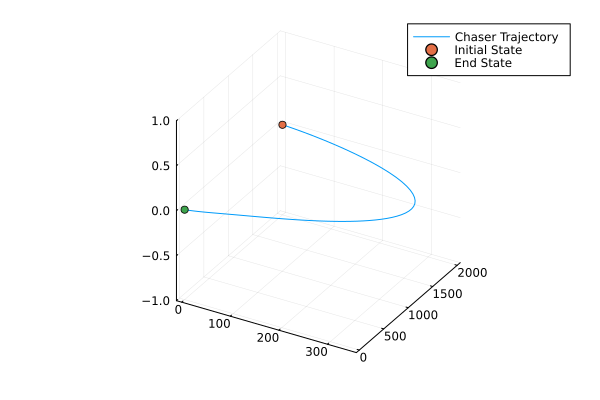

In [54]:
plot(xhist_si[1,:], xhist_si[2,:], xhist_si[3,:], label = "Chaser Trajectory", zlims=(-1,1))

scatter!([xhist_si[1,1]], [xhist_si[2,1]], [xhist_si[3,1]], label = "Initial State")
scatter!([xhist_si[1,end]], [xhist_si[2,end]], [xhist_si[3,end]], label = "End State")

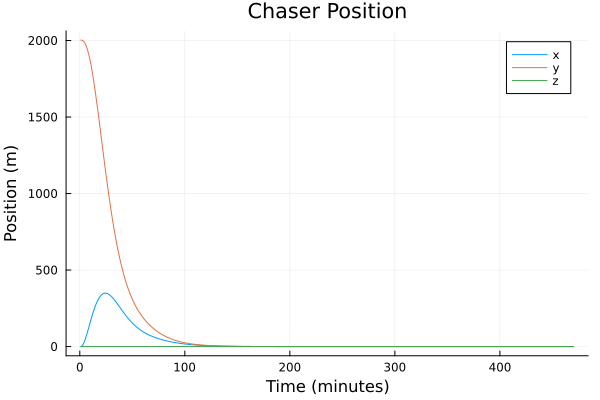

In [55]:
plot(xhist_si[1,:], title= "Chaser Position", xlabel = "Time (minutes)", ylabel = "Position (m)", label = 'x')
plot!(xhist_si[2,:], label='y')
plot!(xhist_si[3,:], label = 'z')

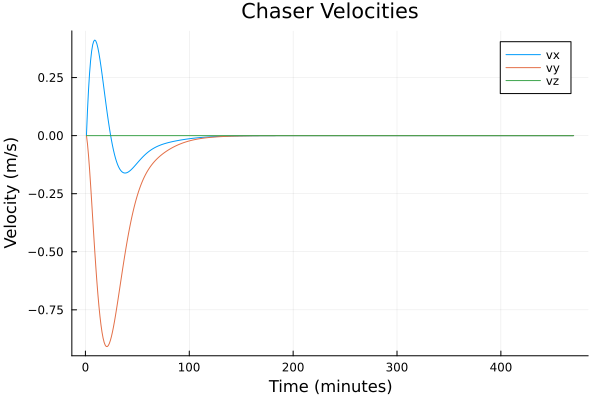

In [71]:
plot(xhist_si[4,:], title= "Chaser Velocities", xlabel = "Time (minutes)", ylabel = "Velocity (m/s)", label = "vx")
plot!(xhist_si[5,:], label="vy")
plot!(xhist_si[6,:], label="vz")

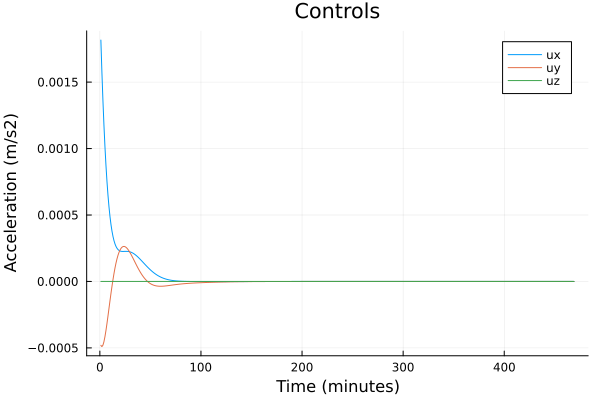

In [57]:
plot(uhist_si[1,:], title= "Controls", xlabel = "Time (minutes)", ylabel = "Acceleration (m/s2)", label = "ux")
plot!(uhist_si[2,:], label="uy")
plot!(uhist_si[3,:], label = "uz")

In [59]:
#norm of the controls 
controls_l1norm = zeros(N-1)
controls_l2norm = zeros(N-1)

469-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [61]:
for i=1:N-1
    
    controls_l1norm[i] = norm(uhist_si[:,i], 1)
    controls_l2norm[i] = norm(uhist_si[:,i], 2)

end

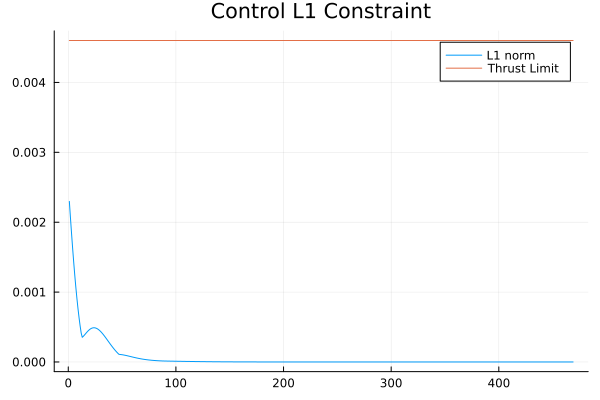

In [63]:
plot(controls_l1norm, label = "L1 norm", title= "Control L1 Constraint")
plot!(ones(N-1)*umax, label = "Thrust Limit")

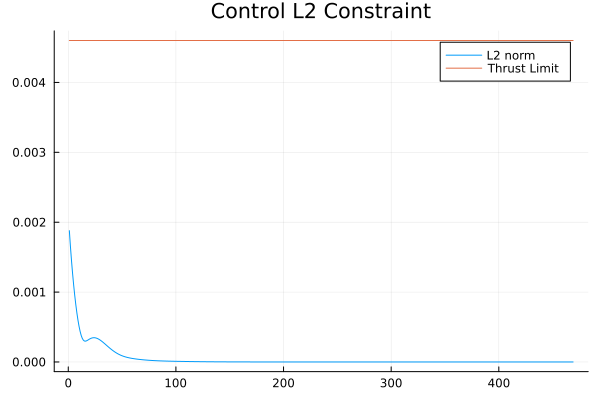

In [64]:
plot(controls_l2norm, label = "L2 norm", title= "Control L2 Constraint")
plot!(ones(N-1)*umax, label = "Thrust Limit")

In [66]:
#simulate the system with no control 
x_no_control = zeros(6, N)

6×470 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [67]:
x_no_control[:,1] = x_initial 

6-element StaticArraysCore.SVector{6, Float64} with indices SOneTo(6):
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [69]:
#simulating no control 

for i = 1:N-1

    x_no_control[:,i+1] = Ad*x_no_control[:,i]

end

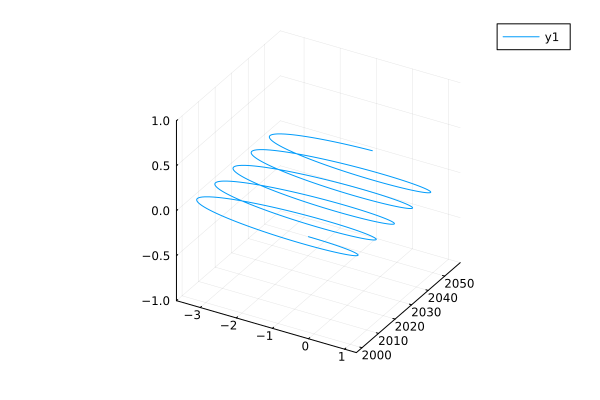

In [70]:
plot(x_no_control[1,:], x_no_control[2,:], x_no_control[3,:], zlims = (-1,1)) 